# "WeRateDogs" Twitter Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import re
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

<h2 style="color:orange">1. Gather</h2>

Gather data from `twitter-archive-enriched.csv`.

In [2]:
df_tweet = pd.read_csv('../data/weratedogs_twitter/twitter-archive-enhanced.csv')
print(df_tweet.shape)
df_tweet.head(2)

(2356, 17)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


Gather data from `image-predictions.tsv`.

In [3]:
df_img = pd.read_csv('../data/weratedogs_twitter/image-predictions.tsv', sep='\t')
print(df_img.shape)
df_img.head(2)

(2075, 12)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


Gather additional data from Twitter API.

In [4]:
# Read tweet_json.txt file line by line and append it to dataframe
df_addition = pd.DataFrame()
with open('../data/weratedogs_twitter/tweet_json.txt') as file:
    lines = file.readlines()
    for line in lines:
        line_dict = json.loads(line)
        line_dict_filtered = {key: line_dict[key] for key in line_dict.keys()  & {'id','retweet_count','favorite_count'}} 
        df_addition = df_addition.append(line_dict_filtered, ignore_index=True)

df_addition.rename(columns={'id':'tweet_id'}, inplace=True)
print(df_addition.shape)
df_addition.head(2)

(2331, 3)


,favorite_count,tweet_id,retweet_count
0,36143.0,8.924206e+17,7696.0
1,31161.0,8.921774e+17,5693.0


<h2 style="color:orange">2. Assess</h2>

In [5]:
# Visually assess data
df_tweet.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
941,752932432744185856,NaN,NaN,2016-07-12 18:27:35 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Carl. He's very powerful. 12/10 don't ...,NaN,NaN,NaN,https://vine.co/v/OEppMFbejFz,12,10,Carl,None,None,None,None
2019,672125275208069120,NaN,NaN,2015-12-02 18:48:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is just impressive I have nothing else to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672125275...,11,10,just,None,None,None,None
253,844704788403113984,NaN,NaN,2017-03-23 00:18:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,None,None,None,None
966,750383411068534784,NaN,NaN,2016-07-05 17:38:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoe. She was trying to stealthily take...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750383411...,9,10,Zoe,None,None,pupper,None
787,774639387460112384,NaN,NaN,2016-09-10 16:03:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sprinkles. He's trapped in light jail....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/774639387...,10,10,Sprinkles,None,None,None,None


In [6]:
# Show dataframe info: dtype, missing data 
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
# Show number of unique values
df_tweet.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [8]:
# rating_numerator, rating_denominator (int)
# Describe those columns
df_tweet.loc[:,['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [9]:
# doggo, floofer, pupper, and puppo columns only have 2 unique values. 
# Get to know those values
print(df_tweet.doggo.unique())
print(df_tweet.floofer.unique())
print(df_tweet.pupper.unique())
print(df_tweet.puppo.unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


<div style="color:blue">
Dataset <b>df_tweet</b>. Findings:
<ul>
    <li><b>timestamp</b> column has <u>wrong data type</u> (string). It should be in datetime.</li>
    <li><b>retweeted_status_timestamp</b> column has <u>wrong data type</u> (string). It should be in datetime.</li>
    <li><b>source</b> column is <u>dirty</u> due to contains html tag in its values.</li>
    <li><b>rating_denominator</b> column has <u>invalid data</u> due to contains value>10.</li>
    <li><b>name</b> column has <u>invalid data</u> due to contains 'None' string value.</li>
    <li><b>doggo, floofer, pupper, and puppo</b> columns have values either 'None' string value or equal to their column name.</li>
    <li>Dataset still contains retweet and reply. 77 of observations are tweet replies. 181 of observations are retweets.</li>
</ul>
</div>

In [10]:
# Visually assess data
df_img.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
278,670995969505435648,https://pbs.twimg.com/media/CU_bRIEWcAAUVC7.jpg,1,redbone,0.866221,True,beagle,0.061194,True,Rhodesian_ridgeback,0.024285,True
1971,869227993411051520,https://pbs.twimg.com/media/DBAePiVXcAAqHSR.jpg,1,Pembroke,0.664181,True,Chihuahua,0.169234,True,Cardigan,0.132700,True
1163,735137028879360001,https://pbs.twimg.com/media/CjO7OfeWgAAUQy-.jpg,1,Walker_hound,0.413535,True,beagle,0.233891,True,English_foxhound,0.164943,True
1840,837820167694528512,https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg,1,golden_retriever,0.887625,True,Labrador_retriever,0.068718,True,kuvasz,0.030387,True
1431,773247561583001600,https://pbs.twimg.com/media/Crsgi9dWEAApQd8.jpg,1,seat_belt,0.713588,False,miniature_pinscher,0.083369,True,Brabancon_griffon,0.075696,True


In [11]:
# Show dataframe info: dtype, missing data 
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
# Show number of unique values
df_img.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [13]:
# Check duplicate
sum(df_img.duplicated()==True)

0

In [14]:
# img_num, p1_conf, p2_conf, p3_conf
# Describe those columns
df_img.loc[:,['img_num','p1_conf','p2_conf','p3_conf']].describe()

,img_num,p1_conf,p2_conf,p3_conf
count,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1.203855,0.594548,1.345886e-01,6.032417e-02
std,0.561875,0.271174,1.006657e-01,5.090593e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1.000000,0.843855,1.955655e-01,9.180755e-02
max,4.000000,1.000000,4.880140e-01,2.734190e-01


<div style="color:blue">
Dataset <b>df_img</b>. Findings:
<ul>
    <li><b>p1, p2, and p3</b> show same variable forms.</li>
    <li><b>p1_conf, p2_conf, and p3_conf</b> show same variable forms.</li>
    <li><b>p1_dog, p2_dog, and p3_dog</b> show same variable forms.</li>
    <li>1 tweet in this dataset has 1 jpg_url value and has 1 img_num value.</li>
    <li>1 tweet in this dataset has 3 prediction results.</li>
</ul>
</div>

In [15]:
# Visually assess data
df_addition.sample(5)

,favorite_count,tweet_id,retweet_count
256,12586.0,8.414399e+17,3664.0
395,0.0,8.232696e+17,10005.0
161,17880.0,8.596078e+17,1486.0
2307,275.0,6.663454e+17,128.0
483,12035.0,8.131273e+17,3190.0


In [16]:
# Show dataframe info: dtype, missing data 
df_addition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   favorite_count  2331 non-null   float64
 1   tweet_id        2331 non-null   float64
 2   retweet_count   2331 non-null   float64
dtypes: float64(3)
memory usage: 54.8 KB


In [17]:
# Check duplicate
sum(df_addition.duplicated()==True)

0

In [18]:
# Describe dataset
df_addition.describe()

,favorite_count,tweet_id,retweet_count
count,2331.000000,2.331000e+03,2331.000000
mean,7545.948520,7.419079e+17,2700.687688
std,11711.242645,6.823170e+16,4565.913539
min,0.000000,6.660209e+17,1.000000
25%,1317.500000,6.782670e+17,547.000000
50%,3282.000000,7.182469e+17,1266.000000
75%,9243.000000,7.986692e+17,3140.000000
max,155881.000000,8.924206e+17,77687.000000


<div style="color:blue">
Dataset <b>df_addition</b>. Findings:
<ul>
    <li><b>favorite_count</b> has wrong datatype (float). It should be integer.</li>
    <li><b>retweet_count</b> has wrong datatype (float). It should be integer.</li>
    <li>Inconsistent datatype for <b>tweet_id</b> in this dataset compared to other 2 datasets. It should be integer.</li>
    <li>Show same observation unit with df_tweet. It should be merged to us get tidy data.</li>
</ul>
</div>

------------

Key Point 1: Get **only original ratings** (no retweets, no replies) that **have images**.

In [19]:
# How many original rating (no retweets, no replies) observations?
df_tweet_ori = df_tweet[df_tweet['in_reply_to_status_id'].isna() & df_tweet['retweeted_status_id'].isna()]
print('There are {} observations which are original ratings.'.format(df_tweet_ori.shape[0]))

There are 2097 observations which are original ratings.


In [20]:
# How many original rating (no retweets, no replies) observations that have images?
df_tweet_ori_img = df_tweet_ori.merge(df_img.loc[:,['tweet_id','jpg_url','img_num']],how='inner',on='tweet_id')
print('There are {} observations which are original ratings and have images.'.format(df_tweet_ori_img.shape[0]))

There are 1971 observations which are original ratings and have images.


In [21]:
# Show dataframe info: dtype, missing data 
df_tweet_ori_img.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1971 non-null   object 
 4   source                      1971 non-null   object 
 5   text                        1971 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1971 non-null   object 
 10  rating_numerator            1971 non-null   int64  
 11  rating_denominator          1971 non-null   int64  
 12  name                        1971 non-null   object 
 13  doggo                       1971 

<div style="color:blue">
Key Point 1. Findings:
<ul>
    <li>There are 1971 observations which are original ratings and have images.</li>
    <li>in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns are no longer needed. We can remove these columns.</li>
</ul>
</div>

Key Point 2: The **ratings probably aren't all correct**. The fact that the rating numerators are greater than the denominators does not need to be cleaned. 

In [22]:
# Common knowledge, the maximum of rating denominator is equal to 10
# Let's investigate observations which have rating denominator greater than 10
print('There are {} observations which have rating_denominator>10.\n'.format(df_tweet_ori_img[df_tweet_ori_img['rating_denominator']>10].shape[0]))

There are 15 observations which have rating_denominator>10.



In [23]:
for x in df_tweet_ori_img[df_tweet_ori_img['rating_denominator']>10].index:
    print("Stored score: "+
          str(df_tweet_ori_img.loc[x,'rating_numerator'])+"/"+
          str(df_tweet_ori_img.loc[x,'rating_denominator']))
    print("Text: "+df_tweet_ori_img.loc[x,'text']+"\n")

Stored score: 84/70
Text: The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd

Stored score: 165/150
Text: Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE

Stored score: 9/11
Text: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

Stored score: 204/170
Text: Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv

Stored score: 4/20
Text: Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a

Stored score: 50/50
Text: This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq

Stored score: 99/90
Text: Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1

Stored score: 80/80
Text: Here's a brigade of puppers. All look very prepared for whatever

In [24]:
# Let's investigate observations which have rating denominator less than 10
print('There are {} observations which have rating_denominator<10.\n'.format(df_tweet_ori_img[df_tweet_ori_img['rating_denominator']<10].shape[0]))

There are 2 observations which have rating_denominator<10.



In [25]:
for x in df_tweet_ori_img[df_tweet_ori_img['rating_denominator']<10].index:
    print("Stored score: "+
          str(df_tweet_ori_img.loc[x,'rating_numerator'])+"/"+
          str(df_tweet_ori_img.loc[x,'rating_denominator']))
    print("Text: "+df_tweet_ori_img.loc[x,'text']+"\n")

Stored score: 24/7
Text: Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx

Stored score: 1/2
Text: This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv



<div style="color:blue">
Key Point 2. Findings:
<ul>
    <li>There are 15 observations which have invalid ratings due to rating_denominator>10. The causes of rating_denominator>10 are (1) Incorrectly extract the score that it should, (2) Some tweets give score to more than a dog in a tweet.</li>
    <li>There are 2 observations which have invalid ratings due to rating_denominator < 10. The causes of rating_denominator < 10 are (1) Incorrectly extract the score that it should, (2) A tweet didn't mention score.</li>
</ul>
</div>

Key Point 3: The **dog name probably aren't all correct**. 

In [26]:
# How many invalid dog name due to 'None' string value?
print('There are {} observations which have invalid dog name due to \'None\' string value.'.\
      format(df_tweet_ori_img[df_tweet_ori_img['name']=='None'].shape[0]))

There are 524 observations which have invalid dog name due to 'None' string value.


In [27]:
# Is 'None' dog name because of an error when extracting?
for x in df_tweet_ori_img[df_tweet_ori_img['name']=='None'].sample(5).index:
    print("Text: "+df_tweet_ori_img.loc[x,'text']+"\n")

Text: When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq

Text: Let's hope this flight isn't Malaysian (lol). What a dog! Almost completely camouflaged. 10/10 I trust this pilot https://t.co/Yk6GHE9tOY

Text: Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl

Text: I've never seen a dog so genuinely happy about a tennis ball. 12/10 s'cute https://t.co/9RYY2NtHDw

Text: Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0



<div style='color: blue'>Findings: 'None' dog name because the dog's name is not mentioned in the tweet.</div>

In [28]:
# Investigate dog names which didn't use capitalize case
df_tweet_ori_img[df_tweet_ori_img['name'].apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False)].name.unique()

array(['such', 'a', 'quite', 'one', 'incredibly', 'very', 'my', 'not',
       'his', 'an', 'just', 'getting', 'this', 'unacceptable', 'all',
       'infuriating', 'the', 'actually', 'by', 'officially', 'light',
       'space'], dtype=object)

In [29]:
# How many dog name which didn't use capitalize case?
print('There are {} observations which have dog name which didn\'t use capitalize case.'.\
      format(sum(df_tweet_ori_img['name'].apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False))))

There are 98 observations which have dog name which didn't use capitalize case.


In [30]:
# Is this because of an error when extracting?
for x in df_tweet_ori_img[df_tweet_ori_img['name'].\
                          apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False)==True].\
                          sample(5).index:
    print("Name: "+df_tweet_ori_img.loc[x,'name'])
    print("Text: "+df_tweet_ori_img.loc[x,'text']+"\n")

Name: a
Text: This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI

Name: not
Text: What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX

Name: by
Text: This is by far the most coordinated series of pictures I was sent. Downright impressive in every way. 12/10 for all https://t.co/etzLo3sdZE

Name: one
Text: Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK

Name: light
Text: This is light saber pup. Ready to fight off evil with light saber. 10/10 true hero https://t.co/LPPa3btIIt



<div style='color: blue'>
Findings: 
<ul>
    <li>Dog names which didn't use capitalize case because error when extracting it from text. </li>
    <li>We should clean this by re-extract dog name which match these search 'named {}' or 'name is {}', and replace with None for others.</li>
</div>

In [31]:
# Investigate dog names which use capitalize case, not 'None', and have length<4 characters
df_tweet_ori_img[df_tweet_ori_img['name'].\
                 apply(lambda x: True if x!='None' and 
                       re.search('^[^A-Z]',x)==None and 
                       len(x)<4 else False)].name.unique()

array(['Jax', 'Ted', 'Jim', 'Gus', 'Rey', 'Aja', 'Jed', 'Leo', 'Max',
       'Ava', 'Eli', 'Ash', 'Mia', 'Ike', 'Mo', 'Bo', 'Tom', 'Ken', 'Alf',
       'Sky', 'Tyr', 'Moe', 'Sam', 'Ito', 'Doc', 'Jay', 'Mya', 'O', 'Al',
       'Lou', 'Dex', 'Ace', 'Zoe', 'Blu', 'Sid', 'Ole', 'Bob', 'Obi',
       'Evy', 'Tug', 'Jeb', 'Dot', 'Eve', 'Mac', 'Ed', 'Taz', 'Cal', 'JD',
       'Pip', 'Amy', 'Gin', 'Edd', 'Ben', 'Dug', 'Jo', 'Ron', 'Stu'],
      dtype=object)

In [32]:
# Investigate dog names which use capitalize case, not 'None', and have length<3 characters
df_tweet_ori_img[df_tweet_ori_img['name'].\
                 apply(lambda x: True if x!='None' and 
                       re.search('^[^A-Z]',x)==None and 
                       len(x)<3 else False)].name.unique()

array(['Mo', 'Bo', 'O', 'Al', 'Ed', 'JD', 'Jo'], dtype=object)

In [33]:
# How many dog name which have name length<3 characters?
print('There are {} observations which have dog name length<3 characters.'.\
      format(sum(df_tweet_ori_img['name'].apply(lambda x: True if x!='None' and re.search('^[^A-Z]',x)==None and len(x)<3 else False))))

There are 12 observations which have dog name length<3 characters.


In [34]:
# Is dog name length<3 because of an error when extracting?
for x in df_tweet_ori_img[df_tweet_ori_img['name'].\
                 apply(lambda x: True if x!='None' and re.search('^[^A-Z]',x)==None and len(x)<3 else False)].index:
    print("Name: "+df_tweet_ori_img.loc[x,'name'])
    print("Text: "+df_tweet_ori_img.loc[x,'text']+"\n")

Name: Mo
Text: This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5

Name: Bo
Text: This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1

Name: Bo
Text: This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq

Name: Bo
Text: This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN

Name: O
Text: This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC

Name: Al
Text: Meet Al Cabone. He's a gangsta puppa. Rather h*ckin ruthless. Shows no mercy sometimes. 11/10 pet w extreme caution https://t.co/OUwWbEKOUV

Name: Bo
Text: This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK

Name: Bo
Text: This is Bo. He emanates happiness. 12/

<div style='color: blue'>
Findings: 
<ul>
    <li>Dog names which have length < 3 characters is caused either the name is only 2 characters or there is an error when extracting.</li>
    <li>We should clean this by re-extract dog name which match these search 'This is {}.' or 'Meet {}.'.</li>
</div>

<div style="color:blue">
Key Point 3. Recap findings:
<ul>
    <li>There are 524 observations which have invalid dog name due to <b>'None' string value</b>, because the dog's name is not mentioned in the tweet. <br/>We should replace those with None.</li>
    <li>There are 98 observations which have dog name which didn't use capitalize case, because <b>error when extracting</b> it from text. <br/>We should clean this by re-extract dog name which match these search 'named {}' or 'name is {}', and replace with None for others.</li>
    <li>There are 12 observations which have dog name <b>length < 3 characters</b>. <br/>We should clean this by re-extract dog name which match these search 'This is {}.' or 'Meet {}.'.</li>
</ul>
</div>

Key Point 4: The **dog stages probably aren't all correct**. 

In [35]:
# Is there an observation which has >1 dog stages?
df_tweet_ori_img['stage_num'] = (df_tweet_ori_img['doggo'].apply(lambda x: 0 if x=='None' else 1)+\
                        df_tweet_ori_img['floofer'].apply(lambda x: 0 if x=='None' else 1)+\
                        df_tweet_ori_img['pupper'].apply(lambda x: 0 if x=='None' else 1)+\
                        df_tweet_ori_img['puppo'].apply(lambda x: 0 if x=='None' else 1))
print('There are {} observations which have >1 dog stages.'.format(df_tweet_ori_img.query('stage_num>1').shape[0]))

There are 10 observations which have >1 dog stages.


In [36]:
# Let's investigate observations which have >1 dog stages
for x in df_tweet_ori_img[df_tweet_ori_img['stage_num']>1].index:
    print("# Stage: "+
          str(df_tweet_ori_img.loc[x,'stage_num']))
    print("Text: "+df_tweet_ori_img.loc[x,'text']+"\n")

# Stage: 2
Text: Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel

# Stage: 2
Text: At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk

# Stage: 2
Text: This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7

# Stage: 2
Text: Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho

# Stage: 2
Text: This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj

# Stage: 2
Text: This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 

In [37]:
# Is there an observation which unknown dog stage?
df_tweet_ori_img['stage_num'] = (df_tweet_ori_img['doggo'].apply(lambda x: 0 if x=='None' else 1)+\
                        df_tweet_ori_img['floofer'].apply(lambda x: 0 if x=='None' else 1)+\
                        df_tweet_ori_img['pupper'].apply(lambda x: 0 if x=='None' else 1)+\
                        df_tweet_ori_img['puppo'].apply(lambda x: 0 if x=='None' else 1))
print('There are {} observations which unknown dog stage.'.format(df_tweet_ori_img.query('stage_num==0').shape[0]))

There are 1668 observations which unknown dog stage.


<div style="color:blue">
Key Point 4. Findings:
<ul>
    <li>There are 10 observations which have >1 dog stages. The most causes of these: there is more than a dog in a tweet.</li>
    <li>doggo, floofer, pupper, and puppo columns have values either 'None' string value or equal to their column name. <br/>We should clean these columns by converting them to bool dtype columns.</li>
</ul>
</div>

<h3 style="color:brown">2.1 Summary of Quality Issues</h3>
<p>Twitter Archive "Enriched" Data (df_tweet) :</p>
<ol>
<li>Dataset still contains retweet and reply. 77 of observations are tweet replies. 181 of observations are retweets.</li>
<li><b>timestamp</b> column has <u>wrong data type</u> (string). It should be in datetime.</li>
<li><b>source</b> column is <u>dirty</u> due to contains html tag in its values.</li>
<li><b>rating_denominator</b> column has <u>invalid data</u> due to greater than 10 or less than 10. It is caused: (1) Incorrectly extract the score from text, (2) Some tweets give score to more than a dog in a tweet, (3) Tweet didn't mention score.</li>
<li><b>rating_numerator</b> column has <u>invalid data</u> due to (1) Incorrectly extract the score from text, (2) Some tweets give score to more than a dog in a tweet, (3) Tweet didn't mention score.</li>
<li><b>name</b> column has <u>invalid data</u> due to (1) contains 'None' string value or (2) incorrect when extracting from text.</li>
<li><b>doggo</b> column has values either 'None' string value or equal to its column name. It should be stored in boolean dtype column.</li>
<li><b>floofer</b> column has values either 'None' string value or equal to its column name. It should be stored in boolean dtype column.</li>
<li><b>pupper</b> column has values either 'None' string value or equal to its column name. It should be stored in boolean dtype column.</li>
<li><b>puppo</b> column has values either 'None' string value or equal to its column name. It should be stored in boolean dtype column.</li>
</ol>
<p>Twitter API Data (df_addition) :</p>
<ol>
<li><b>favorite_count</b> has wrong datatype (float). It should be integer.</li>
<li><b>retweet_count</b> has wrong datatype (float). It should be integer.</li>
<li><b>id</b> (tweet_id) has wrong datatype (float). It should be integer.</li>
</ol>
</div>

<h3 style="color:brown">2.2 Summary of Tidy-ness Issues</h3>
<p>Image Predictions (df_img) :</p>
<ol>
<li>Prediction results are <u>messily stored</u>. p1, p2, and p3 show same variable forms. p1_conf, p2_conf, and p3_conf show same variable forms. p1_dog, p2_dog, and p3_dog show same variable forms. <br/>We should create a separate dataset (observation unit = prediction results) by transforming those columns to be observations and only keep 4 columns: tweet_id, prediction_result, prediction_conf, prediction_dog.</li>
<li>Each type of observational unit forms a table, therefore jpg_url and img_num columns from this dataset should be merged to df_tweet.</li>
</ol>
<p>Tweet API (df_addition) :</p>
<ol>
<li>Show same observation unit with df_tweet. It should be merged it with df_tweet to us get tidy data.</li>
</ol>

---------------

<h2 style="color:orange">3. Clean</h2>

<h3 style="color:brown">3.1 Tweet Dataset (df_tweet_clean)</h3>

***Define***<br/>
Get only original ratings (no retweets, no replies) that have images.
<ul>
<li>Filter out observations in df_tweet which have is_reply_to_status_id value or retweeted_status_id value.</li>
<li>Merge (inner) df_tweet and df_img (jpg_url, img_num columns) on tweet_id</li>
<li>Copy dataset df_tweet_clean.</li>
<li>Remove *retweet* and *reply* columns.</li>
</ul>

***Code***

In [38]:
df_tweet_ori = df_tweet[df_tweet['in_reply_to_status_id'].isna() & df_tweet['retweeted_status_id'].isna()]
df_tweet_ori_img = df_tweet_ori.merge(df_img.loc[:,['tweet_id','jpg_url','img_num']],how='inner',on='tweet_id')

df_tweet_clean = df_tweet_ori_img.copy()
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 19)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


***Test***

In [39]:
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1971 non-null   object 
 4   source                      1971 non-null   object 
 5   text                        1971 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1971 non-null   object 
 10  rating_numerator            1971 non-null   int64  
 11  rating_denominator          1971 non-null   int64  
 12  name                        1971 non-null   object 
 13  doggo                       1971 

<div style='color:blue'>
Results:
<ul>
<li>We have successfully filtered out replies and retweet. All observations have null value for in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns.</li>
<li>We have successfully filtered out observations which didn't have images. All observations have value for jpg_url and img_num columns.</li>
<li>Next, we will remove in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns because they are no longer needed.</li>
</ul>
</div>    

In [40]:
# Remove unnecessary columns
cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
df_tweet_clean.drop(cols,axis=1,inplace=True)
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 14)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


<div style='color:blue'>
Results:
<ul>
<li>We have successfully removed in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns. Now, we have observation shape (1971, 14).</li>
</ul>
</div>    

***Define***<br/>
Convert datatype df_tweet_clean.**timestamp** from string to datetime.

***Code***

In [41]:
print("Previous dtype: {}".format(df_tweet_clean['timestamp'].dtype))
df_tweet_clean['timestamp'] = pd.to_datetime(df_tweet_clean['timestamp'])

Previous dtype: object


***Test***

In [42]:
print("Current dtype: {}".format(df_tweet_clean['timestamp'].dtype))

Current dtype: datetime64[ns, UTC]


<div style='color:blue'>
Results:
<ul>
<li>We have successfully converted datatype of timestamp from string (object) to datetime.</li>
</ul>
</div>    

***Define***<br/>
Replace df_tweet_clean.**source** column values by appling function to get source url.

***Code***

In [43]:
def extract_source_url(text):
    soup = BeautifulSoup(text)
    for a in soup.find_all('a', href=True):
        return a['href']

In [44]:
print("Previous unique: {}".format(df_tweet_clean['source'].unique()))
df_tweet_clean['source'] = df_tweet_clean['source'].apply(lambda x: extract_source_url(x))

Previous unique: ['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>']


***Test***

In [45]:
print("Current unique: {}".format(df_tweet_clean['source'].unique()))

Current unique: ['http://twitter.com/download/iphone' 'http://twitter.com'
 'https://about.twitter.com/products/tweetdeck']


<div style='color:blue'>
Results:
<ul>
<li>We have successfully cleaned value of source by only store source url.</li>
</ul>
</div>    

***Define***<br/>
Get Correct rating_numerator and rating_denominator by reextracting from text.

***Code***

In [46]:
def extract_rating(text, var):
    num = 0
    denom = 0 
    for score in re.findall('\d+\.?\d*/\d+\.?\d*',text):
        num, denom = float((score.split('/')[0])), float((score.split('/')[1]))
    
    if var=='denom': return denom
    else: return num

In [47]:
df_tweet_clean['tmp_numerator'] = df_tweet_clean['text'].apply(lambda x: extract_rating(x,'num'))
df_tweet_clean['tmp_denominator'] = df_tweet_clean['text'].apply(lambda x: extract_rating(x,'denom'))

***Test***

In [48]:
cols = ['tweet_id','rating_numerator','rating_denominator','tmp_numerator','tmp_denominator']
df_tweet_clean.loc[:,cols].query('rating_numerator!=tmp_numerator & rating_denominator!=tmp_denominator')

,tweet_id,rating_numerator,rating_denominator,tmp_numerator,tmp_denominator
794,740373189193256964,9,11,14.0,10.0
884,722974582966214656,4,20,13.0,10.0
918,716439118184652801,50,50,11.0,10.0
1313,682962037429899265,7,11,10.0,10.0
1950,666287406224695296,1,2,9.0,10.0


In [49]:
sum(df_tweet_clean['tmp_denominator']!=10)

12

In [50]:
# Replace df_tweet_clean: rating_numerator, rating_denominator by tmp_numerator, tmp_denominator.
df_tweet_clean['rating_numerator'] = df_tweet_clean['tmp_numerator']
df_tweet_clean['rating_denominator'] = df_tweet_clean['tmp_denominator']

# Remove columns df_tweet_clean: tmp_numerator, tmp_denominator.
cols = ['tmp_numerator', 'tmp_denominator']
df_tweet_clean.drop(cols,axis=1,inplace=True)
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 14)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


***Define***<br/>
Standardize rating scale: max of denominator is equal to 10.

***Code***

In [51]:
def clean_rating_num(df):
    if df['rating_denominator']>10:
        return df['rating_numerator']/(df['rating_denominator']/10)
    elif df['rating_denominator']<10:
        mlp = 10*1.0/df['rating_denominator']
        return (df['rating_numerator'] * mlp)
    else: 
        return df['rating_numerator']

In [52]:
# Apply clean_rating_num function replace rating_numerator with rating_numerator divided by num of dogs.
df_tweet_clean['tmp_numerator'] = df_tweet_clean.apply(clean_rating_num, axis=1)
df_tweet_clean['tmp_denominator'] = df_tweet_clean['rating_denominator'].apply(lambda x: 10 if x!=10 else x)

***Test***

In [53]:
cols = ['tweet_id','rating_numerator','rating_denominator','tmp_numerator','tmp_denominator']
df_tweet_clean.loc[:,cols].query('rating_numerator!=tmp_numerator & rating_denominator!=tmp_denominator')

,tweet_id,rating_numerator,rating_denominator,tmp_numerator,tmp_denominator
320,820690176645140481,84.0,70.0,12.000000,10.0
382,810984652412424192,24.0,7.0,34.285714,10.0
658,758467244762497024,165.0,150.0,11.000000,10.0
842,731156023742988288,204.0,170.0,12.000000,10.0
939,713900603437621249,99.0,90.0,11.000000,10.0
963,710658690886586372,80.0,80.0,10.000000,10.0
981,709198395643068416,45.0,50.0,9.000000,10.0
1045,704054845121142784,60.0,50.0,12.000000,10.0
1120,697463031882764288,44.0,40.0,11.000000,10.0
1288,684222868335505415,121.0,110.0,11.000000,10.0


In [54]:
# Replace df_tweet_clean: rating_numerator, rating_denominator by tmp_numerator, tmp_denominator.
df_tweet_clean['rating_numerator'] = df_tweet_clean['tmp_numerator']
df_tweet_clean['rating_denominator'] = df_tweet_clean['tmp_denominator']

# Remove columns df_tweet_clean: tmp_numerator, tmp_denominator.
cols = ['tmp_numerator', 'tmp_denominator']
df_tweet_clean.drop(cols,axis=1,inplace=True)
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 14)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


In [55]:
# Is still there rating_denominator!=10 ?
sum(df_tweet_clean['rating_denominator']!=10)

0

In [56]:
# Rename rating_numerator to rating. 
df_tweet_clean.rename(columns={'rating_numerator':'rating'}, inplace=True)

# Drop rating_denominator column due to we have standardized all tweet use rating scale max to 10.
df_tweet_clean.drop(['rating_denominator'],axis=1,inplace=True)

<div style='color:blue'>
Results:
<ul>
<li>We have successfully cleaned value of rating_numerator and rating_denominator where rating_denominator is equal to 10.</li>
<li>We have successfully renamed rating_numerator column to rating and drop unnecessary rating_denominator column.</li>
</ul>
</div>    

***Define***<br/>
Get correct dog name by re-extracting from text for dog names which didn't use capitalize case or have length < 3 characters. Pattern: 'named {}', 'name is {}', 'This is {}', or 'Meet {}'.

***Code***

In [57]:
def extract_name_from_text(text):
    name = None
    if len(re.findall(r'name is [A-Z][A-Za-z\']+',text)) > 0:
        name = re.findall(r'name is [A-Z][A-Za-z\']+',text)[0][len('name is '):]
    elif len(re.findall(r'named [A-Z][A-Za-z\']+',text)) > 0:
        name = re.findall(r'named [A-Z][A-Za-z\']+',text)[0][len('named '):]
    elif len(re.findall(r'This is [A-Z][A-Za-z\']+',text)) > 0:
        name = re.findall(r'This is [A-Z][A-Za-z\']+',text)[0][len('This is '):]
    elif len(re.findall(r'Meet [A-Z][A-Za-z\']+',text)) > 0:
        name = re.findall(r'Meet [A-Z][A-Za-z\']+',text)[0][len('Meet '):]
        
    return name

In [58]:
# Create new column tmp_name by applying extract_name_from_text function.
df_tweet_clean['tmp_name'] = df_tweet_clean['text'].apply(lambda x: extract_name_from_text(x))

***Test 1***

In [59]:
# Are we successfully cleaned name which previously stored in uncapitalize case?
cols = ['tweet_id','name','tmp_name']
df_tweet_clean[df_tweet_clean['name']\
               .apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False)]\
            .loc[:,cols].query('name!=tmp_name & name!="None"').sample(5)

,tweet_id,name,tmp_name
1942,666407126856765440,a,None
1262,685943807276412928,the,None
1036,704859558691414016,a,None
1817,668815180734689280,a,None
1853,668171859951755264,a,Alfonso


In [60]:
for x in df_tweet_clean[df_tweet_clean['name']\
                          .apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False)==True].\
                          sample(5).index:
    print("Name: {}".format(df_tweet_clean.loc[x,'name']))
    print("Cleaned Name: {}".format(df_tweet_clean.loc[x,'tmp_name']))
    print("Text: "+df_tweet_clean.loc[x,'text']+"\n")

Name: a
Cleaned Name: Jacob
Text: This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7

Name: a
Cleaned Name: None
Text: Here is a mother dog caring for her pups. Snazzy red mohawk. Doesn't wag tail. Pups look confused. Overall 4/10 https://t.co/YOHe6lf09m

Name: a
Cleaned Name: None
Text: Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq

Name: a
Cleaned Name: Klint
Text: This is a southwest Coriander named Klint. Hat looks expensive. Still on house arrest :(
9/10 https://t.co/IQTOMqDUIe

Name: a
Cleaned Name: None
Text: This is a baby Rand Paul. Curls for days. 11/10 would cuddle the hell out of https://t.co/xHXNaPAYRe



In [61]:
# Apply to clean dog names which stored in uncapilatilize case
index = df_tweet_clean[df_tweet_clean['name']\
                       .apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False)].index

df_tweet_clean.loc[index,['name']] = df_tweet_clean[df_tweet_clean['name']\
                                                    .apply(lambda x: True if re.search('^[^A-Z]',x)!=None else False)].tmp_name

***Test 2***

In [62]:
# Are we successfully cleaned name which previously have name length <3 characters?
cols = ['tweet_id','name','tmp_name']
df_tweet_clean[df_tweet_clean['name']\
               .apply(lambda x: True if x!=None 
                      and x!='None' 
                      and re.search('^[^A-Z]',x)==None 
                      and len(x)<3 else False)].loc[:,cols].query('name!=tmp_name & name!="None"')

,tweet_id,name,tmp_name
557,776201521193218049,O,O'Malley


In [63]:
# Apply to clean dog names which have length < 3 characters
index = df_tweet_clean[df_tweet_clean['name']\
               .apply(lambda x: True if x!=None 
                      and x!='None' 
                      and re.search('^[^A-Z]',x)==None 
                      and len(x)<3 else False)].index

df_tweet_clean.loc[index,['name']] = df_tweet_clean[df_tweet_clean['name']\
                                                    .apply(lambda x: True if x!=None 
                                                           and x!='None' 
                                                           and re.search('^[^A-Z]',x)==None 
                                                           and len(x)<3 else False)].tmp_name

***Define***<br/>
Get correct dog name by replace 'None' string by None.

***Code***

In [64]:
# Code: Apply to clean dog names which equal to 'None' string
index = df_tweet_clean[df_tweet_clean['name']=='None'].index

df_tweet_clean.loc[index,['name']] = None

***Test***

In [65]:
# Are we successfully cleaned name from 'None' string to None?
sum(df_tweet_clean['name']=='None')

0

In [66]:
# Remove columns df_tweet_clean: tmp_name.
cols = ['tmp_name']
df_tweet_clean.drop(cols,axis=1,inplace=True)
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 13)


,tweet_id,timestamp,source,text,expanded_urls,rating,name,doggo,floofer,pupper,puppo,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


<div style='color:blue'>
Results:
<ul>
<li>We have successfully cleaned value of name. There is no more 'None' names and invalid values.</li>
</ul>
</div>    

***Define***<br/>
Clean **doggo, floofer, pupper, and puppo** column values.
<ul>
<li>Create convert_to_boolean function to return False if column value is equal to 'None' and return True for else.</li>
<li>Create new columns (df_tweet_clean: is_doggo, is_floofer, is_pupper, is_puppo) by applying convert_to_boolean function to .doggo, floofer, pupper, and puppo columns.</li>
<li>Remove df_tweet_clean: doggo, floofer, pupper, and puppo columns.</li>
</ul>

***Code***

In [67]:
# Create function to convert doggo, floofer, pupper, and puppo values to boolean
def convert_to_boolean(text):
    if text=='None': return False
    else: return True

In [68]:
# Apply convert_to_boolean function to doggo, floofer, pupper, and puppo values
df_tweet_clean['is_doggo']=df_tweet_clean['doggo'].apply(lambda x: convert_to_boolean(x))
df_tweet_clean['is_floofer']=df_tweet_clean['floofer'].apply(lambda x: convert_to_boolean(x))
df_tweet_clean['is_pupper']=df_tweet_clean['pupper'].apply(lambda x: convert_to_boolean(x))
df_tweet_clean['is_puppo']=df_tweet_clean['puppo'].apply(lambda x: convert_to_boolean(x))
df_tweet_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating,name,doggo,floofer,pupper,puppo,jpg_url,img_num,is_doggo,is_floofer,is_pupper,is_puppo
555,776477788987613185,2016-09-15 17:48:25+00:00,http://twitter.com/download/iphone,This is Huck. He's addicted to caffeine. Hope ...,https://twitter.com/dog_rates/status/776477788...,11.0,Huck,None,None,pupper,None,https://pbs.twimg.com/media/CsaaaaxWgAEfzM7.jpg,1,False,False,True,False
1256,686358356425093120,2016-01-11 01:25:58+00:00,http://twitter.com/download/iphone,Heartwarming scene here. Son reuniting w fathe...,https://twitter.com/dog_rates/status/686358356...,10.0,None,None,None,None,None,https://pbs.twimg.com/media/CYZvRttWYAE_RXc.jpg,1,False,False,False,False
1191,690690673629138944,2016-01-23 00:21:03+00:00,http://twitter.com/download/iphone,This is Cedrick. He's a spookster. Did me a di...,https://twitter.com/dog_rates/status/690690673...,10.0,Cedrick,None,None,None,None,https://pbs.twimg.com/media/CZXTgKkWwAA5UZJ.jpg,1,False,False,False,False
766,744971049620602880,2016-06-20 19:11:53+00:00,http://twitter.com/download/iphone,Say hello to Indie and Jupiter. They're having...,https://twitter.com/dog_rates/status/744971049...,12.0,Indie,None,None,None,None,https://pbs.twimg.com/media/ClarNU8VAAEDrDt.jpg,1,False,False,False,False
54,880221127280381952,2017-06-29 00:27:25+00:00,http://twitter.com/download/iphone,Meet Jesse. He's a Fetty Woof. His tongue ejec...,https://twitter.com/dog_rates/status/880221127...,12.0,Jesse,None,None,None,None,https://pbs.twimg.com/media/DDcscbXU0AIfDzs.jpg,1,False,False,False,False


***Test***

In [69]:
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       1971 non-null   int64              
 1   timestamp      1971 non-null   datetime64[ns, UTC]
 2   source         1971 non-null   object             
 3   text           1971 non-null   object             
 4   expanded_urls  1971 non-null   object             
 5   rating         1971 non-null   float64            
 6   name           1371 non-null   object             
 7   doggo          1971 non-null   object             
 8   floofer        1971 non-null   object             
 9   pupper         1971 non-null   object             
 10  puppo          1971 non-null   object             
 11  jpg_url        1971 non-null   object             
 12  img_num        1971 non-null   int64              
 13  is_doggo       1971 non-null   bool             

In [70]:
# Remove columns df_tweet_clean: 'doggo','floofer','pupper','puppo'.
cols = ['doggo','floofer','pupper','puppo']
df_tweet_clean.drop(cols,axis=1,inplace=True)
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 13)


,tweet_id,timestamp,source,text,expanded_urls,rating,name,jpg_url,img_num,is_doggo,is_floofer,is_pupper,is_puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,False,False,False,False
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,False,False,False,False
2,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,False,False,False,False
3,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,False,False,False,False
4,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,False,False,False,False


<div style='color:blue'>
Results:
<ul>
<li>We have successfully cleaned doggo, floofer, pupper, and puppo columns by replacing them with 4 new columns which have boolean datatype.</li>
</ul>
</div>    

***Define***<br/>Copy df_addition and convert datatype of all columns to integer.

***Code***

In [71]:
# Copy, convert datatype, rename columns
df_addition_clean = df_addition.copy()
df_addition_clean = df_addition_clean.astype('int64')
df_addition_clean.rename(columns={'favorite_count':'favorite_num','retweet_count':'retweet_num'}, inplace=True)

***Test***

In [72]:
df_addition_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   favorite_num  2331 non-null   int64
 1   tweet_id      2331 non-null   int64
 2   retweet_num   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [73]:
df_addition_clean.sample(5)

,favorite_num,tweet_id,retweet_num
1192,3702,714982300363173888,1024
1979,1308,672466075045466112,509
2003,1079,671866342182637568,473
1379,2069,699413908797464576,623
1357,2203,700890391244103680,563


<div style='color:blue'>
Results:
<ul>
<li>We have successfully cleaned Twitter Additional dataset by converting tweet_id, favorite_count, and retweet_count datatype from float to integer datatype.</li>
</ul>
</div>    

***Define***<br/>Merge df_tweet_clean and df_addition_clean (left)

***Code***

In [74]:
# Merge df_tweet_clean and df_addition_clean (left)
df_tweet_clean = df_tweet_clean.merge(df_addition_clean, how='left', on='tweet_id')
print(df_tweet_clean.shape)
df_tweet_clean.head()

(1971, 15)


,tweet_id,timestamp,source,text,expanded_urls,rating,name,jpg_url,img_num,is_doggo,is_floofer,is_pupper,is_puppo,favorite_num,retweet_num
0,892420643555336193,2017-08-01 16:23:56+00:00,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,False,False,False,False,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,False,False,False,False,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,False,False,False,False,23481.0,3775.0
3,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,False,False,False,False,39409.0,7852.0
4,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,False,False,False,False,37623.0,8469.0


***Test***

In [75]:
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       1971 non-null   int64              
 1   timestamp      1971 non-null   datetime64[ns, UTC]
 2   source         1971 non-null   object             
 3   text           1971 non-null   object             
 4   expanded_urls  1971 non-null   object             
 5   rating         1971 non-null   float64            
 6   name           1371 non-null   object             
 7   jpg_url        1971 non-null   object             
 8   img_num        1971 non-null   int64              
 9   is_doggo       1971 non-null   bool               
 10  is_floofer     1971 non-null   bool               
 11  is_pupper      1971 non-null   bool               
 12  is_puppo       1971 non-null   bool               
 13  favorite_num   1282 non-null   float64          

<div style='color:blue'>
Results:
<ul>
<li>We have successfully get a tidy dataset (1 observation unit) by merging df_tweet_clean and df_addition_clean.</li>
<li>From 1971 observations, only 1282 observations have favorite_num and retweet_num info.</li>
</ul>
</div>    

<h3 style="color:brown">3.2 Image Prediction Dataset (df_img_clean)</h3>

***Define***<br/>Get image prediction results where 1 prediction in 1 row.
- Concat 1st prediction result from df_img with 2nd prediction result. And concat them with 3rd prediction result.
- Filter to get only original tweet
- Copy dataset

***Code***

In [76]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [77]:
# Transform to 1 prediction result = 1 row
cols1 = ['tweet_id','p1','p1_conf','p1_dog']
cols2 = ['tweet_id','p2','p2_conf','p2_dog']
cols3 = ['tweet_id','p3','p3_conf','p3_dog']
rename_cols1 = {'p1':'prediction_result','p1_conf':'prediction_conf','p1_dog':'prediction_is_dog'}
rename_cols2 = {'p2':'prediction_result','p2_conf':'prediction_conf','p2_dog':'prediction_is_dog'}
rename_cols3 = {'p3':'prediction_result','p3_conf':'prediction_conf','p3_dog':'prediction_is_dog'}

print("df_img shape: {}".format(df_img.shape))
df_img_clean = pd.concat([df_img.loc[:,cols1].rename(columns=rename_cols1), 
                          df_img.loc[:,cols2].rename(columns=rename_cols2), 
                          df_img.loc[:,cols3].rename(columns=rename_cols3)], sort=False).copy()

df_img shape: (2075, 12)


***Test***

In [78]:
print("df_img_clean shape: {}".format(df_img_clean.shape))
df_img_clean.head()

df_img_clean shape: (6225, 4)


,tweet_id,prediction_result,prediction_conf,prediction_is_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,redbone,0.506826,True
2,666033412701032449,German_shepherd,0.596461,True
3,666044226329800704,Rhodesian_ridgeback,0.408143,True
4,666049248165822465,miniature_pinscher,0.560311,True


In [79]:
# Remove rows which their tweet_id didn't exist in df_tweet_clean
df_img_clean = df_img_clean.merge(df_tweet_clean.loc[:,['tweet_id']], how='inner', on='tweet_id')
print(df_img_clean.shape)
df_img_clean.head()

(5913, 4)


,tweet_id,prediction_result,prediction_conf,prediction_is_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,collie,0.156665,True
2,666020888022790149,Shetland_sheepdog,0.061428,True
3,666029285002620928,redbone,0.506826,True
4,666029285002620928,miniature_pinscher,0.074192,True


<div style='color:blue'>
Results:
<ul>
<li>We have successfully transformed to get 1 row = 1 prediction result and copy dataset and named it with df_img_clran.</li> 
<li>We have successfully filtered out replies and retweet.</li>
</ul>
</div>    

<h3 style="color:brown">3.3 Summary of Cleaning Data Result</h3>
<ol>
<li>Finally, we have successfully cleaned and created 2 tidy dataset, i.e. df_tweet_clean and df_img_clean.</li>
<li><b>df_tweet_clean</b> contains 1971 original tweets data (not retweets, not replies) where 1 row = 1 tweet.</li>
<li><b>df_img_clean</b> contains top 3 image prediction results of 1971 original tweets where 1 row = 1 image prediction.</li>
</ol>

--------

<h2 style="color:orange">4. Store</h2>

Store the clean DataFrame(s) in a CSV file with the main one named `twitter_archive_master.csv`.

In [80]:
df_tweet_clean.to_csv('../data/weratedogs_twitter/twitter_archive_master.csv', index=False)

In [81]:
df_img_clean.to_csv('../data/weratedogs_twitter/image_prediction_master.csv', index=False)

--------

<h2 style="color:orange">5. Analyze & Visualize</h2>

Research question: How about rating distribution?

In [82]:
# Describe columns to get to know their summary statistic
df_tweet_clean['rating'].describe()

count    1971.000000
mean       11.648435
std        40.879397
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating, dtype: float64

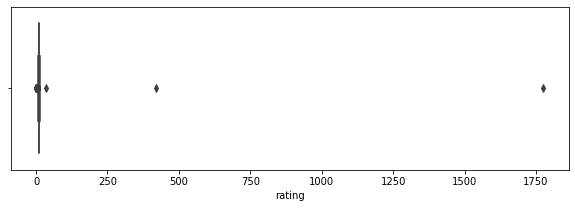

In [83]:
plt.figure(figsize=(10,3))
sns.boxplot(x="rating", data=df_tweet_clean, dodge=False);

<div style='color:blue'>Insight: Most of tweets have rating 11/10. <br/>Another findings, I found there is outlier in rating value which probably invalid data. 75% of tweets have rating less than or equal to 12, but there is a tweet which have rating 1776 in our dataset.</div>

Research question: How about favorite and retweet distribution?

In [84]:
# Describe columns to get to know their summary statistic
df_tweet_clean[['favorite_num','retweet_num']].describe()

,favorite_num,retweet_num
count,1282.000000,1282.000000
mean,7783.931357,2297.100624
std,10903.718526,3716.460614
min,70.000000,11.000000
25%,1587.000000,525.000000
50%,3562.000000,1146.500000
75%,9582.250000,2732.750000
max,120395.000000,56630.000000


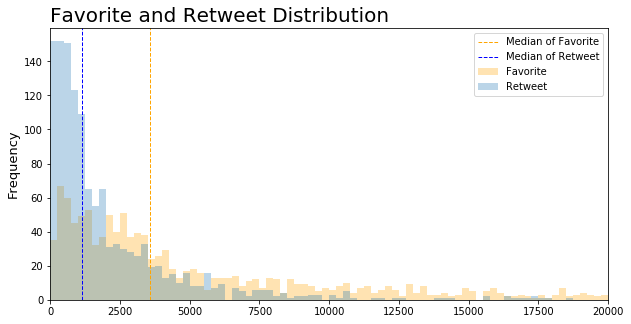

In [85]:
# Visualize favorite num and retweet num distribution
# Bin size 
bin_edges = np.arange(0, 120500, 250)

plt.figure(figsize=(10,5));
plt.hist(df_tweet_clean['favorite_num'], bins=bin_edges, alpha=0.3, color='orange', label='Favorite');
plt.hist(df_tweet_clean['retweet_num'], bins=bin_edges, alpha=0.3, label='Retweet');

plt.axvline(df_tweet_clean['favorite_num'].median(), color='orange', linestyle='dashed', linewidth=1, label='Median of Favorite')
plt.axvline(df_tweet_clean['retweet_num'].median(), color='blue', linestyle='dashed', linewidth=1, label='Median of Retweet')

# Set x-axis limit
plt.xlim(0,20000)

# Add legend
plt.legend(loc=1, ncol=1);

# Add titles
plt.title("Favorite and Retweet Distribution", loc='left', fontsize=20, fontweight=0, color='black');
plt.ylabel("Frequency", fontsize=13);

<div style='color:blue'>Insight: Most of original tweets in WeRateDogs have 1146 retweets and have been favorited by 3562 twitter accounts.</div>

Research question: Which properties have correlation?

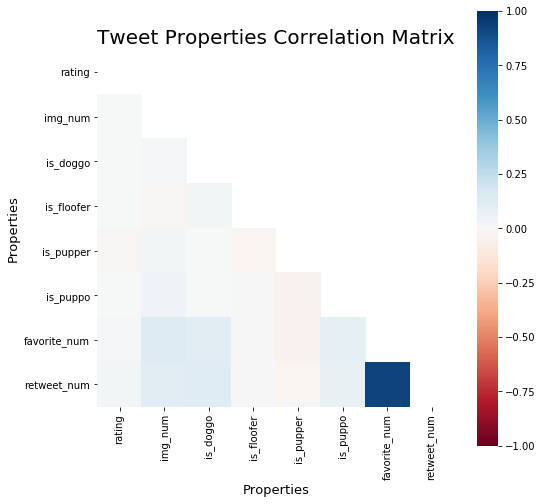

In [86]:
corrs = (df_tweet_clean.iloc[:,1:]).corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8));
sns.heatmap(corrs, cmap='RdBu', mask=mask, square=True, vmin=-1, vmax=1);

# Add titles
plt.title("Tweet Properties Correlation Matrix", loc='left', fontsize=20, fontweight=0, color='black');
plt.xlabel("Properties", fontsize=13);
plt.ylabel("Properties", fontsize=13);

In [87]:
corrs[corrs['favorite_num']>=0.5].favorite_num

favorite_num    1.000000
retweet_num     0.925566
Name: favorite_num, dtype: float64

<div style='color:blue'>Insight: Num of favorite and num of retweet have moderate positive corelation.</div>

Research question: What is the most popular dog names?

In [88]:
word_string = " ".join(df_tweet_clean[df_tweet_clean['name'].isna()==False].name.str.lower())
word_cloud = WordCloud(background_color='white', max_words=300).generate(word_string)

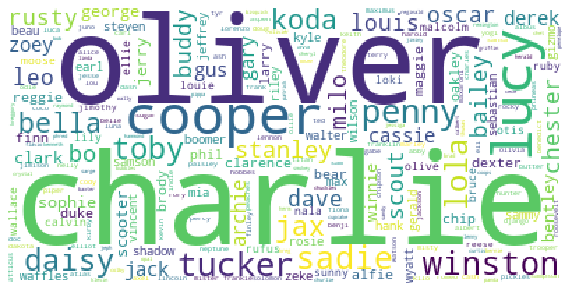

In [89]:
plt.figure(figsize=(10,10))
plt.clf()
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [90]:
1971-sum(df_tweet_clean['name'].isna())

1371

In [91]:
(df_tweet_clean.groupby('name', as_index=False)[['tweet_id']].count()).sort_values(['tweet_id'],ascending=False).head(10)

,name,tweet_id
169,Charlie,11
209,Cooper,10
640,Oliver,10
548,Lucy,10
665,Penny,9
883,Tucker,9
751,Sadie,8
915,Winston,8
867,Toby,7
226,Daisy,7


<div style='color:blue'>Insight: Charlie, Oliver, Chooper, and Lucy are the most popular dog names that we get from 1371 observations from "WeRateDogs" Twitter Archive Dataset.</div>

Research question: How many observations which their top 3 prediction results said that is not a dog(s)?

In [92]:
df_img_not_dog = df_img_clean.query('prediction_is_dog==False')
df_img_not_dog_agg = df_img_not_dog.groupby(['tweet_id'], as_index=False)[['prediction_is_dog']].count()

df_img_not_dog_agg[df_img_not_dog_agg['prediction_is_dog']==3].shape[0]

305

In [93]:
print(df_img_not_dog_agg[df_img_not_dog_agg['prediction_is_dog']==3].merge(df_tweet_clean,how='inner',on='tweet_id').loc[0,'expanded_urls'])
print(df_img_not_dog_agg[df_img_not_dog_agg['prediction_is_dog']==3].merge(df_tweet_clean,how='inner',on='tweet_id').loc[1,'expanded_urls'])
print(df_img_not_dog_agg[df_img_not_dog_agg['prediction_is_dog']==3].merge(df_tweet_clean,how='inner',on='tweet_id').loc[2,'expanded_urls'])

https://twitter.com/dog_rates/status/666051853826850816/photo/1
https://twitter.com/dog_rates/status/666104133288665088/photo/1
https://twitter.com/dog_rates/status/666268910803644416/photo/1


In [94]:
df_img_not_dog_agg[df_img_not_dog_agg['prediction_is_dog']==3].merge(df_img_clean,how='inner',on='tweet_id').head(9)

,tweet_id,prediction_is_dog_x,prediction_result,prediction_conf,prediction_is_dog_y
0,666051853826850816,3,box_turtle,0.933012,False
1,666051853826850816,3,mud_turtle,0.045885,False
2,666051853826850816,3,terrapin,0.017885,False
3,666104133288665088,3,hen,0.965932,False
4,666104133288665088,3,cock,0.033919,False
5,666104133288665088,3,partridge,0.000052,False
6,666268910803644416,3,desktop_computer,0.086502,False
7,666268910803644416,3,desk,0.085547,False
8,666268910803644416,3,bookcase,0.079480,False


<div style='color:blue'>Insight: Based on top 3 prediction results of each tweet, there are 305 of 1971 tweets that are predicted not attach picture of dog(s).</div>